**File Contents:**
1. Merge initial data sets\
    1.1. Hit\
    1.2. Sessions\
    1.3. Merge\
2. Data Preparation\
    2.1.  Data Сleaning\
    2.2.  Data Transformation\
    2.3.	Data Standartization\
    2.4.	Data Encoding
3.	Modeling\
    3.1. LogReg\
        3.1.1. Hyperparameter Selection\
        3.1.2. Best LogReg\
    3.2. Random Forest\
        3.2.1. Hyperparameter Selection\
        3.2.2. Best Random Forest\
    3.3. Best Model
4. Result


In [1]:
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# 1. Merge initial data sets

## 1.1. Hit

**The initial data was loaded from the file.\
The events were distinguished as target/non-target (1/0) according to the task for subsequent training of the model within the binary classification task.\
Duplicates removed.**

**Data description:**\
session_id — visit ID;\
hit_ate — event date;\
hit_time — event time;\
hit_number — event sequence number within the session;\
hit_type — event type;\
hit_referer — event source;\
hit_page_path — event page;\
event_category — action type;\
event_action — action;\
event_label — action tag;\
event_value — action result valueu

In [2]:
df1 = pd.read_csv('./data/ga_hits.csv')
df1.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [4]:
target_events = ['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click',
                 'sub_custom_question_submit_click', 'sub_call_number_click', 'sub_callback_submit_click',
                 'sub_submit_success', 'sub_car_request_submit_click']

In [5]:
df1 = df1.drop_duplicates()

In [6]:
df1_1 = df1.copy()
df1_1.event_action = df1_1.event_action.apply(lambda x: 1 if x in target_events else 0)
df1_1.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,0,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,0,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,0,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,0,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,0,NaN,NaN


In [7]:
df1_1.event_action.value_counts()

0    15621562
1      104908
Name: event_action, dtype: int64

In [8]:
df1_short = df1_1.groupby(['session_id'])[['event_action']].sum()
df1_short.event_action = df1_short.event_action.apply(lambda x: 1 if x>=1 else 0)
df1_short.event_action.value_counts()

0    1683850
1      50760
Name: event_action, dtype: int64

## 1.2. Sessions

**The initial data was loaded from the file.\
Duplicates removed.**

**Data description:**\
session_id - visit ID;\
client_id - visitor ID;\
visit_date - visit date;\
visit_time - visit time;\
visit_number - client visit ordinal number;\
utm_source - acquisition channel;\
utm_medium - acquisition type;\
utm_campaign - advertising campaign;\
utm_adcontent - content;\
utm_keyword - keyword;
device_category - device type;\
device_os - device OS;\
device_brand - device brand;\
device_model - device model;\
device_screen_resolution - screen resolution;\
device_browser - browser;\
geo_country - country;\
geo_city - city.

In [9]:
df2 = pd.read_csv('./data/ga_sessions.csv')
df2.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


In [11]:
df2 = df2.drop_duplicates()

## 1.3. Merge

**Merging of two datasets was performed.\
Removed uninformative attributes**

In [18]:
df[df.event_action  == 1]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,event_action
69,9055768928391199041.1623652678.1623652678,2108460508.162365,2021-06-14,09:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Huawei,NaN,360x780,Chrome,Russia,Moscow,1
73,9055789093275396095.1636395007.1636395007,2108465203.16364,2021-11-08,21:10:07,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,414x736,Safari,Russia,Samara,1
76,9055794766915104430.1624305327.1624305327,2108466524.16243,2021-06-21,22:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,NaN,desktop,NaN,NaN,NaN,834x1112,Safari,Russia,Domodedovo,1
127,9056028189803556573.1630154471.1630154471,2108520872.163016,2021-08-28,15:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,412x915,YaBrowser,Russia,Krasnodar,1
135,9056093322981390023.1628944098.1628944098,2108536037.162894,2021-08-14,15:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,360x740,Chrome,Russia,Moscow,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732152,9054912872702758664.1636781836.1636781836,2108261192.163678,2021-11-13,08:37:16,1,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,NaN,HKFjmDlYppkKqsWPogJt,mobile,Android,Xiaomi,NaN,360x800,Chrome,Russia,Moscow,1
1732225,9055248417020050011.1634073188.1634073188,2108339317.163408,2021-10-13,00:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,SgIUDYUKnyWHVowUOqid,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Huawei,NaN,360x780,Chrome,Russia,Nizhny Novgorod,1
1732227,9055248417020050011.1634075541.1634075541,2108339317.163408,2021-10-13,00:00:00,3,ZpYIoDJMcFzVoPFsHGJL,banner,SgIUDYUKnyWHVowUOqid,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Huawei,NaN,360x780,Chrome,Russia,Nizhny Novgorod,1
1732254,9055376699099939975.1630766214.1630766214,2108369185.163077,2021-09-04,17:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,desktop,NaN,NaN,NaN,1920x1080,Chrome,Russia,Khimki,1


In [12]:
df = pd.merge(left=df2, right=df1_short, on='session_id', how='inner')
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,event_action
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0


In [13]:
df.shape

(1732266, 19)

In [14]:
missing_values = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)
missing_values

device_model                99.130503
utm_keyword                 58.925823
device_os                   58.533966
device_brand                20.042880
utm_adcontent               17.557177
utm_campaign                11.273500
utm_source                   0.004387
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
event_action                 0.000000
dtype: float64

In [15]:
# Remove uninformative columns
df_new = df.drop(columns=['session_id', 'client_id', 'device_os', 'visit_time', 'device_model',
                          'device_screen_resolution', 'device_browser'])
df_new.head()

,visit_date,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_brand,geo_country,geo_city,event_action
0,2021-11-24,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Huawei,Russia,Zlatoust,0
1,2021-11-14,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Samsung,Russia,Moscow,0
2,2021-12-28,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Huawei,Russia,Krasnoyarsk,0
3,2021-05-29,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,Xiaomi,Russia,Moscow,0
4,2021-05-29,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,Xiaomi,Russia,Moscow,0


In [16]:
df_new.to_csv('./data/df_new.csv', index=False)

# 2. Data Preparation

In [18]:
df_train, df_test = train_test_split(df_new, stratify=df_new['event_action'], test_size=0.3, random_state=42)

## 2.1. Data Сleaning

**Some attributes with NaN were filled with a constant and some with a mode.\
Replaced unassigned values with "other".**

In [19]:
missing_values = (df_train.isna().sum() / len(df_train) * 100).sort_values(ascending=False)
missing_values

utm_keyword        58.913017
device_brand       20.042372
utm_adcontent      17.521231
utm_campaign       11.249924
utm_source          0.004536
visit_date          0.000000
visit_number        0.000000
utm_medium          0.000000
device_category     0.000000
geo_country         0.000000
geo_city            0.000000
event_action        0.000000
dtype: float64

In [20]:
for column in df_train.columns:
    print(
        f'\n\nValue counts for: "{column}"\n'
        f'{df_train[column].value_counts()}')



Value counts for: "visit_date"
2021-05-24    27531
2021-12-21    20940
2021-05-25    13374
2021-06-29    11793
2021-09-14    11020
              ...  
2021-06-05     1426
2021-05-23      787
2021-05-21      565
2021-05-22      535
2021-05-19      504
Name: visit_date, Length: 226, dtype: int64


Value counts for: "visit_number"
1      910929
2      148587
3       50325
4       25627
5       15122
        ...  
534         1
401         1
387         1
495         1
354         1
Name: visit_number, Length: 485, dtype: int64


Value counts for: "utm_source"
ZpYIoDJMcFzVoPFsHGJL    386984
fDLlAcSmythWSCVMvqvL    194278
kjsLglQLzykiRbcDiGcD    171274
MvfHsxITijuriZxsqZqt    123168
BHcvLfOaCWvWTykYqHVe     77751
                         ...  
JcVHXwVSrnfIuOMMEkrJ         1
zGUBrOvMRpLqBkJPUsYo         1
SHJidRpqXditMCUeEFzb         1
labpJCBQmsoWLfQvNTak         1
VdeFdoGCqZBxFfKSHNLl         1
Name: utm_source, Length: 255, dtype: int64


Value counts for: "utm_medium"
banner           

In [21]:
imp_const_other = SimpleImputer(strategy='constant', fill_value='other')

columns_const = ['utm_source', 'utm_campaign', 'utm_adcontent', 'device_brand', 'utm_keyword']

df_train[columns_const] = imp_const_other.fit_transform(df_train[columns_const])
df_test[columns_const] = imp_const_other.transform(df_test[columns_const])

In [22]:
missing_values = (df_train.isna().sum() / len(df_train) * 100).sort_values(ascending=False)
missing_values

visit_date         0.0
visit_number       0.0
utm_source         0.0
utm_medium         0.0
utm_campaign       0.0
utm_adcontent      0.0
utm_keyword        0.0
device_category    0.0
device_brand       0.0
geo_country        0.0
geo_city           0.0
event_action       0.0
dtype: float64

In [23]:
df_train['utm_medium'] = df_train['utm_medium'].apply(lambda x: x.replace('(not set)', 'other').replace('(none)', 'other'))
df_test['utm_medium'] = df_test['utm_medium'].apply(lambda x: x.replace('(not set)', 'other').replace('(none)', 'other'))

In [24]:
mode_country = df_train['geo_country'].mode()[0]
df_train['geo_country'] = df_train['geo_country'].apply(lambda x: x.replace('(not set)', mode_country))
df_test['geo_country'] = df_test['geo_country'].apply(lambda x: x.replace('(not set)', mode_country))

mode_city = df_train['geo_city'].mode()[0]
df_train['geo_city'] = df_train['geo_city'].apply(lambda x: x.replace('(not set)', mode_city))
df_test['geo_city'] = df_test['geo_city'].apply(lambda x: x.replace('(not set)', mode_city))

## 2.2. Data Transformation

**New attributes based on visit_date were created.\
Merged rare values ​​for categorical attributes into "rare".**


In [25]:
# Transform the 'visit_date' column and add features based on this column
def get_data_from_datetime_column(df):
    df = df.copy()
    df['visit_date'] = pd.to_datetime(df['visit_date'])
    df['month'] = df['visit_date'].dt.month
    df['dayofweek'] = df['visit_date'].dt.dayofweek
    df = df.drop(columns=['visit_date'])
    
    return df

In [26]:
df_train = get_data_from_datetime_column(df_train)
df_test = get_data_from_datetime_column(df_test)

In [29]:
# Reduce the number of categories depending on frequency
def get_transform_column_by_frequency(df, column, persent):
    min_count = int(df.shape[0] * persent)
    df_value_counts = df[column].value_counts().to_frame().reset_index()
    df_value_counts.columns = ['unique_value', 'count']
    list_unique_value_with_condition = df_value_counts[df_value_counts['count'] >= min_count]['unique_value'].tolist()
    
    def get_transform_column(value):
        if value in list_unique_value_with_condition:
            new_value = value
        else:
            new_value = 'rare'
    
        return new_value
    
    df[column] = df[column].apply(lambda x: get_transform_column(x))
    
    
    return df[column]

In [30]:
list_categorical_columns = ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword', 'device_category',
                            'device_brand', 'geo_country', 'geo_city']

for column in list_categorical_columns:
    df_train[column] = get_transform_column_by_frequency(df_train, column, 0.001)
    df_test[column] = get_transform_column_by_frequency(df_test, column, 0.001)

## 2.3. Data Standartization

**Numeric attributes were standardized using the MinMaxScale method.**

In [29]:
mmscaler = MinMaxScaler()

mmscaled_train = mmscaler.fit_transform(df_train[['visit_number', 'month', 'dayofweek']])
df_train[['visit_number', 'month', 'dayofweek']] = mmscaled_train
df_train = df_train.drop(columns=['visit_number', 'month', 'dayofweek'])

mmscaled_test = mmscaler.transform(df_test[['visit_number', 'month', 'dayofweek']])
df_test[['visit_number', 'month', 'dayofweek']] = mmscaled_test
df_test = df_test.drop(columns=['visit_number', 'month', 'dayofweek'])

## 2.4. Data Encoding

**Categorical attributes were encoded using the Target Encoding method.**

In [30]:
encoder = TargetEncoder()

df_train[list_categorical_columns] = encoder.fit_transform(df_train[list_categorical_columns], df_train['event_action'])
df_test[list_categorical_columns] = encoder.transform(df_test[list_categorical_columns], df_test['event_action'])

In [31]:
df_train.to_csv('./data/df_train_prepared.csv', index=False)
df_test.to_csv('./data/df_test_prepared.csv', index=False)

# 3. Modeling

**Based on the analysis of the initial data, two models were selected: LogisticRegression and RandomForestClassifier.\
Hyperparameters were selected on a reduced dataset.\
Models with the best hyperparameters were trained on the full training dataset.\
The influence of attributes on model prediction was analyzed. The analysis showed that different models have different contribution of attributes to the predicted result.**


In [32]:
X_train = df_train.drop(['event_action'], axis=1)
y_train = df_train['event_action']

X_test = df_test.drop(['event_action'], axis=1)
y_test = df_test['event_action']

## 3.1. LogReg

In [33]:
logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)

pred_logreg_train = logreg.predict(X_train)
pred_logreg_test = logreg.predict(X_test)

print(
    f'ROC-AUC train_set for LogisticRegression: {roc_auc_score(y_train, logreg.predict_proba(X_train)[:,1])}\n'
    f'ROC-AUC test_set for LogisticRegression: {roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])}\n'
    f'\n'
    f'Precision train_set for LogisticRegression: {precision_score(y_train, pred_logreg_train)}\n'
    f'Precision test_set for LogisticRegression: {precision_score(y_test, pred_logreg_test)}\n'
    f'\n'
    f'Recall train_set for LogisticRegression: {recall_score(y_train, pred_logreg_train)}\n'
    f'Recall test_set for LogisticRegression: {recall_score(y_test, pred_logreg_test)}\n'
    )
print('Confusion_matrix test_set for LogisticRegression:')
confusion_matrix(y_test, pred_logreg_test)

ROC-AUC train_set for LogisticRegression: 0.6534831796447607
ROC-AUC test_set for LogisticRegression: 0.6523645059933767

Precision train_set for LogisticRegression: 0.0430760169362815
Precision test_set for LogisticRegression: 0.04281747011701911

Recall train_set for LogisticRegression: 0.6603350369108462
Recall test_set for LogisticRegression: 0.654763482178349

Confusion_matrix test_set for LogisticRegression:


array([[283652, 220934],
       [  5211,   9883]], dtype=int64)

### 3.1.1. Hyperparameter Selection

In [50]:
# Reduce the dataset so that  to speed up  hyperparameter selection 
df_train_short = df_train.sample(100000)
df_test_short = df_test.sample(30000)

X_train_short = df_train_short.drop(['event_action'], axis=1)
y_train_short = df_train_short['event_action']

X_test_short = df_test_short.drop(['event_action'], axis=1)
y_test_short = df_test_short['event_action']

In [35]:
parameters_logreg = {'penalty': ['l2', 'l1'],
                     'C': [0.1, 1, 5, 10],
                     'solver': ['liblinear', 'saga']
                    }

scores = ['f1', 'roc_auc']

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for score in scores:
    grid = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42),
                                           parameters_logreg, scoring=score, cv=cv, n_jobs=-1)
    grid.fit(X_train_short, y_train_short)
    print(score, grid.best_params_)

f1 {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
roc_auc {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [36]:
#f1
logreg1 = LogisticRegression(C=10, solver='saga', class_weight='balanced', penalty='l2', random_state=42)
logreg1.fit(X_train_short, y_train_short)

pred_logreg_train1 = logreg1.predict(X_train_short)
pred_logreg_test1 = logreg1.predict(X_test_short)

print(
    f'ROC-AUC train for LogisticRegression: {roc_auc_score(y_train_short, logreg1.predict_proba(X_train_short)[:,1])}\n'
    f'ROC-AUC test for LogisticRegression: {roc_auc_score(y_test_short, logreg1.predict_proba(X_test_short)[:,1])}\n'
    f'\n'
    f'Precision train_set for LogisticRegression: {precision_score(y_train_short, pred_logreg_train1)}\n'
    f'Precision test_set for LogisticRegression: {precision_score(y_test_short, pred_logreg_test1)}\n'
    f'\n'
    f'Recall train_set for LogisticRegression: {recall_score(y_train_short, pred_logreg_train1)}\n'
    f'Recall test_set for LogisticRegression: {recall_score(y_test_short, pred_logreg_test1)}\n'
    )
print('Confusion_matrix test_set for LogisticRegression:')
confusion_matrix(y_test_short, pred_logreg_test1)

ROC-AUC train for LogisticRegression: 0.6581285077595085
ROC-AUC test for LogisticRegression: 0.650021741618034

Precision train_set for LogisticRegression: 0.05402946027412842
Precision test_set for LogisticRegression: 0.05126771066368382

Recall train_set for LogisticRegression: 0.3275862068965517
Recall test_set for LogisticRegression: 0.3160919540229885

Confusion_matrix test_set for LogisticRegression:


array([[24041,  5089],
       [  595,   275]], dtype=int64)

In [37]:
#roc-auc
logreg2 = LogisticRegression(C=1, solver='liblinear', class_weight='balanced', penalty='l1', random_state=42, n_jobs=-2)
logreg2.fit(X_train_short, y_train_short)

pred_logreg_train2 = logreg2.predict(X_train_short)
pred_logreg_test2 = logreg2.predict(X_test_short)

print(
    f'ROC-AUC train for LogisticRegression: {roc_auc_score(y_train_short, logreg2.predict_proba(X_train_short)[:,1])}\n'
    f'ROC-AUC test for LogisticRegression: {roc_auc_score(y_test_short, logreg2.predict_proba(X_test_short)[:,1])}\n'
    f'\n'
    f'Precision train_set for LogisticRegression: {precision_score(y_train_short, pred_logreg_train2)}\n'
    f'Precision test_set for LogisticRegression: {precision_score(y_test_short, pred_logreg_test2)}\n'
    f'\n'
    f'Recall train_set for LogisticRegression: {recall_score(y_train_short, pred_logreg_train2)}\n'
    f'Recall test_set for LogisticRegression: {recall_score(y_test_short, pred_logreg_test2)}\n'
    )
print('Confusion_matrix test_set for LogisticRegression:')
confusion_matrix(y_test_short, pred_logreg_test2)

ROC-AUC train for LogisticRegression: 0.6582921392805142
ROC-AUC test for LogisticRegression: 0.6503964392674929

Precision train_set for LogisticRegression: 0.043706617306802406
Precision test_set for LogisticRegression: 0.042684336235457275

Recall train_set for LogisticRegression: 0.6513793103448275
Recall test_set for LogisticRegression: 0.6367816091954023

Confusion_matrix test_set for LogisticRegression:


array([[16705, 12425],
       [  316,   554]], dtype=int64)

In [40]:
threshold_best = 0
f1_best = 0
probs = pd.DataFrame(logreg2.predict_proba(X_train_short))
    
for threshold in np.arange(0.1, 1.0, 0.1):
    classes = (probs[1] > threshold).astype('int')
    f1 = f1_score(y_train_short, classes)

    if f1 > f1_best:
        f1_best = f1
        threshold_best = threshold

probs_test = pd.DataFrame(logreg2.predict_proba(X_test_short))
classes_test = (probs_test[1] > threshold_best).astype('int')

print(
    f'F1 score for LogReg on test set: {f1_score(y_test_short, classes_test)}, threshold = {threshold_best}\n'
    f'{confusion_matrix(y_test_short, classes_test)}'
)

F1 score for LogReg on test set: 0.08853177501826151, threshold = 0.6
[[23458  5672]
 [  567   303]]


In [41]:
parameters_logreg = {'penalty': ['elasticnet'],
                     'C': [0.1, 1, 5, 10],
                     'solver': ['saga'],
                     'class_weight': ['balanced'],
                     'l1_ratio': np.arange(0.4, 0.6, 0.02)
            }

scores = ['f1', 'roc_auc']

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for score in scores:
    grid = GridSearchCV(LogisticRegression(random_state=42), parameters_logreg, scoring=score, cv=cv, n_jobs=-1)
    grid.fit(X_train_short, y_train_short)
    print(score, grid.best_params_)

f1 {'C': 5, 'class_weight': 'balanced', 'l1_ratio': 0.5800000000000002, 'penalty': 'elasticnet', 'solver': 'saga'}
roc_auc {'C': 5, 'class_weight': 'balanced', 'l1_ratio': 0.5600000000000002, 'penalty': 'elasticnet', 'solver': 'saga'}


In [45]:
# Best model
logreg3 = LogisticRegression(C=5, solver='saga', class_weight='balanced', penalty='elasticnet', random_state=42,
                            l1_ratio=0.56, n_jobs=-2)
logreg3.fit(X_train_short, y_train_short)

pred_logreg_train3 = logreg3.predict(X_train_short)
pred_logreg_test3 = logreg3.predict(X_test_short)

print(
    f'ROC-AUC train for LogisticRegression: {roc_auc_score(y_train_short, logreg3.predict_proba(X_train_short)[:,1])}\n'
    f'ROC-AUC test for LogisticRegression: {roc_auc_score(y_test_short, logreg3.predict_proba(X_test_short)[:,1])}\n'
    f'\n'
    f'Precision train_set for LogisticRegression: {precision_score(y_train_short, pred_logreg_train3)}\n'
    f'Precision test_set for LogisticRegression: {precision_score(y_test_short, pred_logreg_test3)}\n'
    f'\n'
    f'Recall train_set for LogisticRegression: {recall_score(y_train_short, pred_logreg_train3)}\n'
    f'Recall test_set for LogisticRegression: {recall_score(y_test_short, pred_logreg_test3)}\n'
    )
print('Confusion_matrix test_set for LogisticRegression:')
confusion_matrix(y_test_short, pred_logreg_test3)

ROC-AUC train for LogisticRegression: 0.6580603022124365
ROC-AUC test for LogisticRegression: 0.6497937111087436

Precision train_set for LogisticRegression: 0.04027839988974262
Precision test_set for LogisticRegression: 0.03979387346120813

Recall train_set for LogisticRegression: 0.8062068965517242
Recall test_set for LogisticRegression: 0.7988505747126436

Confusion_matrix test_set for LogisticRegression:


array([[12360, 16770],
       [  175,   695]], dtype=int64)

### 3.1.2. Best LogReg

In [46]:
logreg_best = LogisticRegression(C=5, solver='saga', class_weight='balanced', penalty='elasticnet', random_state=42,
                                 l1_ratio=0.56, n_jobs=-2)
logreg_best.fit(X_train, y_train)

pred_logreg_best_train = logreg_best.predict(X_train)
pred_logreg_best_test = logreg_best.predict(X_test)

print(
    f'ROC-AUC train_set for LogisticRegression: {roc_auc_score(y_train, logreg_best.predict_proba(X_train)[:,1])}\n'
    f'ROC-AUC test_set for LogisticRegression: {roc_auc_score(y_test, logreg_best.predict_proba(X_test)[:,1])}\n'
    f'\n'
    f'Precision train_set for LogisticRegression: {precision_score(y_train, pred_logreg_best_train)}\n'
    f'Precision test_set for LogisticRegression: {precision_score(y_test, pred_logreg_best_test)}\n'
    f'\n'
    f'Recall train_set for LogisticRegression: {recall_score(y_train, pred_logreg_best_train)}\n'
    f'Recall test_set for LogisticRegression: {recall_score(y_test, pred_logreg_best_test)}\n'
    )
print('Confusion_matrix test_set for LogisticRegression:')
confusion_matrix(y_test, pred_logreg_best_test)

ROC-AUC train_set for LogisticRegression: 0.6536000761362264
ROC-AUC test_set for LogisticRegression: 0.6516676911371024

Precision train_set for LogisticRegression: 0.04085021687971494
Precision test_set for LogisticRegression: 0.04068099598665988

Recall train_set for LogisticRegression: 0.7668938103350369
Recall test_set for LogisticRegression: 0.762885914933086

Confusion_matrix test_set for LogisticRegression:


array([[233045, 271541],
       [  3579,  11515]], dtype=int64)

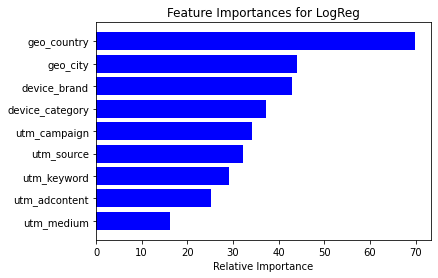

In [47]:
features = X_train.columns
importances_logreg = abs(logreg_best.coef_).ravel()
indices_logreg = np.argsort(importances_logreg)

plt.barh(range(len(indices_logreg)), importances_logreg[indices_logreg], color='b', align='center')
plt.yticks(range(len(indices_logreg)), [features[i] for i in indices_logreg])
plt.title('Feature Importances for LogReg')
plt.xlabel('Relative Importance');

**According to the "Feature Importances for LogReg" histogram, the "geo_country" attribute has the greatest weight.**

## 3.2. Random Forest

In [48]:
rfc = RandomForestClassifier(n_jobs=-2, random_state=42)
rfc.fit(X_train, y_train)

pred_rfc_train = rfc.predict(X_train)
pred_rfc_test = rfc.predict(X_test)

print(
    f'ROC-AUC train_set for RandomForestClassifier: {roc_auc_score(y_train, rfc.predict_proba(X_train)[:, 1])}\n'
    f'ROC-AUC test_set for RandomForestClassifier: {roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])}\n'
    f'\n'
    f'Precision train_set for RandomForestClassifier: {precision_score(y_train, pred_rfc_train)}\n'
    f'Precision test_set for RandomForestClassifier: {precision_score(y_test, pred_rfc_test)}\n'
    f'\n'
    f'Recall train_set for RandomForestClassifier: {recall_score(y_train, pred_rfc_train)}\n'
    f'Recall test_set for RandomForestClassifier: {recall_score(y_test, pred_rfc_test)}\n'
    )

print('Confusion_matrix test_set for RandomForestClassifier:')
confusion_matrix(y_test, pred_rfc_test)

ROC-AUC train_set for RandomForestClassifier: 0.7625439605819191
ROC-AUC test_set for RandomForestClassifier: 0.6523806979471869

Precision train_set for RandomForestClassifier: 0.8832547169811321
Precision test_set for RandomForestClassifier: 0.11349693251533742

Recall train_set for RandomForestClassifier: 0.021266325951164112
Recall test_set for RandomForestClassifier: 0.002451305154365973

Confusion_matrix test_set for RandomForestClassifier:


array([[504297,    289],
       [ 15057,     37]], dtype=int64)

### 3.2.1. Hyperparameter Selection

Reduce the dataset so that  to speed up  hyperparameter selection 

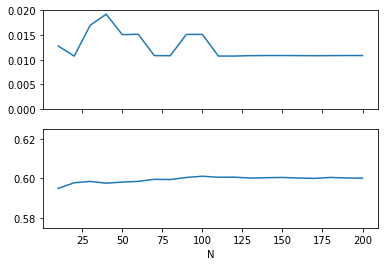

In [51]:
N = []
f1 = []
roc_auc = []

for n in range(10, 210, 10):
    rfc = RandomForestClassifier(n_estimators = n, random_state=42, n_jobs=-2)
    rfc.fit(X_train_short, y_train_short)

    N.append(n)
    f1.append(f1_score(y_test_short, rfc.predict(X_test_short)))
    roc_auc.append(roc_auc_score(y_test_short, rfc.predict_proba(X_test_short)[:, 1]))
    
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(N, f1, '-')
ax[0].set_ylim(0.0, 0.02)
ax[1].plot(N, roc_auc, '-')
ax[1].set_ylim(0.575, 0.625)
plt.xlabel('N')
plt.show();

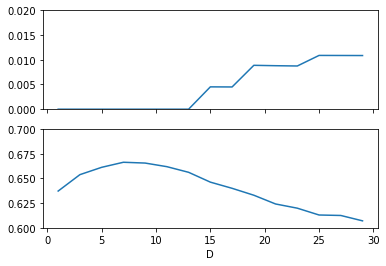

In [52]:
D = []
f1 = []
roc_auc = []

for d in range(1, 30, 2):
    rfc = RandomForestClassifier(n_estimators = 100, max_depth=d, random_state=42, n_jobs=-2)
    rfc.fit(X_train_short, y_train_short)

    D.append(d)
    f1.append(f1_score(y_test_short, rfc.predict(X_test_short)))
    roc_auc.append(roc_auc_score(y_test_short, rfc.predict_proba(X_test_short)[:, 1]))

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(D, f1, '-')
ax[0].set_ylim(0.0, 0.02)
ax[1].plot(D, roc_auc, '-')
ax[1].set_ylim(0.6, 0.7)
plt.xlabel('D')
plt.show();

In [59]:
parameters_rfc = {'n_estimators': [100, 200],
                  'criterion': ['gini', 'log_loss'],
                  'max_depth': [10, 15, 20],
                  'max_features': ['sqrt', 'log2'],
                  'min_samples_split': [2, 50, 100],
                  'class_weight': ['balanced_subsample']
                }

scores = ['f1', 'roc_auc']

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

list_params = []
for score in scores:
    grid = GridSearchCV(RandomForestClassifier(random_state=42), parameters_rfc, scoring=score, cv=cv, n_jobs=-2)
    grid.fit(X_train_short, y_train_short)
    list_params.append((score, grid.best_params_))
    print(score, grid.best_params_)

f1 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 100, 'n_estimators': 200}
roc_auc {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 100, 'n_estimators': 200}


In [60]:
# F1
rfc1 = RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample', criterion='gini', max_depth=15,
                                  max_features='sqrt', min_samples_split=10, n_jobs=-2, random_state=42)
rfc1.fit(X_train_short, y_train_short)

pred_rfc_train1 = rfc1.predict(X_train_short)
pred_rfc_test1 = rfc1.predict(X_test_short)

print(
    f'ROC-AUC train for RandomForestClassifier: {roc_auc_score(y_train_short, rfc1.predict_proba(X_train_short)[:, 1])}\n'
    f'ROC-AUC test for RandomForestClassifier: {roc_auc_score(y_test_short, rfc1.predict_proba(X_test_short)[:, 1])}\n'
    f'\n'
    f'Precision train_set for RandomForestClassifier: {precision_score(y_train_short, pred_rfc_train1)}\n'
    f'Precision test_set for RandomForestClassifier: {precision_score(y_test_short, pred_rfc_test1)}\n'
    f'\n'
    f'Recall train_set for RandomForestClassifier: {recall_score(y_train_short, pred_rfc_train1)}\n'
    f'Recall test_set for RandomForestClassifier: {recall_score(y_test_short, pred_rfc_test1)}\n'
    )

print('Confusion_matrix test_set for RandomForestClassifier:')
confusion_matrix(y_test_short, pred_rfc_test1)

ROC-AUC train for RandomForestClassifier: 0.7894259828118897
ROC-AUC test for RandomForestClassifier: 0.6520655326301833

Precision train_set for RandomForestClassifier: 0.06428761179491721
Precision test_set for RandomForestClassifier: 0.04459486362731435

Recall train_set for RandomForestClassifier: 0.7510344827586207
Recall test_set for RandomForestClassifier: 0.5149425287356322

Confusion_matrix test_set for RandomForestClassifier:


array([[19532,  9598],
       [  422,   448]], dtype=int64)

In [61]:
# ROC AUC -best model
rfc2 = RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample', criterion='gini', max_depth=10,
                                  max_features='sqrt', min_samples_split=100, n_jobs=-2, random_state=42)
rfc2.fit(X_train_short, y_train_short)

pred_rfc_train2 = rfc2.predict(X_train_short)
pred_rfc_test2 = rfc2.predict(X_test_short)

print(
    f'ROC-AUC train for RandomForestClassifier: {roc_auc_score(y_train_short, rfc2.predict_proba(X_train_short)[:, 1])}\n'
    f'ROC-AUC test for RandomForestClassifier: {roc_auc_score(y_test_short, rfc2.predict_proba(X_test_short)[:, 1])}\n'
    f'\n'
    f'Precision train_set for RandomForestClassifier: {precision_score(y_train_short, pred_rfc_train2)}\n'
    f'Precision test_set for RandomForestClassifier: {precision_score(y_test_short, pred_rfc_test2)}\n'
    f'\n'
    f'Recall train_set for RandomForestClassifier: {recall_score(y_train_short, pred_rfc_train2)}\n'
    f'Recall test_set for RandomForestClassifier: {recall_score(y_test_short, pred_rfc_test2)}\n'
    )

print('Confusion_matrix test_set for RandomForestClassifier:')
confusion_matrix(y_test_short, pred_rfc_test2)

ROC-AUC train for RandomForestClassifier: 0.7267199225824781
ROC-AUC test for RandomForestClassifier: 0.673989803930853

Precision train_set for RandomForestClassifier: 0.05003265534614667
Precision test_set for RandomForestClassifier: 0.045134319114345435

Recall train_set for RandomForestClassifier: 0.7396551724137931
Recall test_set for RandomForestClassifier: 0.6701149425287356

Confusion_matrix test_set for RandomForestClassifier:


array([[16796, 12334],
       [  287,   583]], dtype=int64)

In [62]:
probs = pd.DataFrame(rfc2.predict_proba(X_test_short))
    
for threshold in np.arange(0.1, 1.0, 0.1):
    classes = (probs[1] > threshold).astype('int')
    
    print(
        f'\nthreshold = {threshold}\n'
        f'F1 test_set for RandomForestClassifier: {f1_score(y_test_short, classes)}\n'
        f'Precision test_set for RandomForestClassifier: {precision_score(y_test_short, classes)}\n'
        f'Recall test_set for RandomForestClassifier: {recall_score(y_test_short, classes)}'
        )
    print('Confusion_matrix test_set for RandomForestClassifier:')
    print(confusion_matrix(y_test_short, classes))


threshold = 0.1
F1 test_set for RandomForestClassifier: 0.05892393827666256
Precision test_set for RandomForestClassifier: 0.030363802688058546
Recall test_set for RandomForestClassifier: 0.9919540229885058
Confusion_matrix test_set for RandomForestClassifier:
[[ 1571 27559]
 [    7   863]]

threshold = 0.2
F1 test_set for RandomForestClassifier: 0.06273266742840292
Precision test_set for RandomForestClassifier: 0.03240546818476067
Recall test_set for RandomForestClassifier: 0.9781609195402299
Confusion_matrix test_set for RandomForestClassifier:
[[ 3720 25410]
 [   19   851]]

threshold = 0.30000000000000004
F1 test_set for RandomForestClassifier: 0.06965390985964608
Precision test_set for RandomForestClassifier: 0.03619971003986952
Recall test_set for RandomForestClassifier: 0.9183908045977012
Confusion_matrix test_set for RandomForestClassifier:
[[ 7857 21273]
 [   71   799]]

threshold = 0.4
F1 test_set for RandomForestClassifier: 0.07604404737170165
Precision test_set for RandomF

### 3.2.2. Best Random Forest

In [63]:
rfc_best = RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample', criterion='gini', max_depth=10,
                                  max_features='sqrt', min_samples_split=100, n_jobs=-2, random_state=42)
rfc_best.fit(X_train, y_train)

pred_rfc_best_train = rfc_best.predict(X_train)
pred_rfc_best_test = rfc_best.predict(X_test)

print(
    f'ROC-AUC train_set for RandomForestClassifier: {roc_auc_score(y_train, rfc_best.predict_proba(X_train)[:, 1])}\n'
    f'ROC-AUC test_set for RandomForestClassifier: {roc_auc_score(y_test, rfc_best.predict_proba(X_test)[:, 1])}\n'
    f'\n'
    f'Precision train_set for RandomForestClassifier: {precision_score(y_train, pred_rfc_best_train)}\n'
    f'Precision test_set for RandomForestClassifier: {precision_score(y_test, pred_rfc_best_test)}\n'
    f'\n'
    f'Recall train_set for RandomForestClassifier: {recall_score(y_train, pred_rfc_best_train)}\n'
    f'Recall test_set for RandomForestClassifier: {recall_score(y_test, pred_rfc_best_test)}\n'
    )

print('Confusion_matrix test_set for RandomForestClassifier:')
confusion_matrix(y_test, pred_rfc_best_test)

ROC-AUC train_set for RandomForestClassifier: 0.6896025119331931
ROC-AUC test_set for RandomForestClassifier: 0.6805146120151677

Precision train_set for RandomForestClassifier: 0.04470796350958028
Precision test_set for RandomForestClassifier: 0.04382107960916226

Recall train_set for RandomForestClassifier: 0.7405451448040886
Recall test_set for RandomForestClassifier: 0.7249900622764012

Confusion_matrix test_set for RandomForestClassifier:


array([[265809, 238777],
       [  4151,  10943]], dtype=int64)

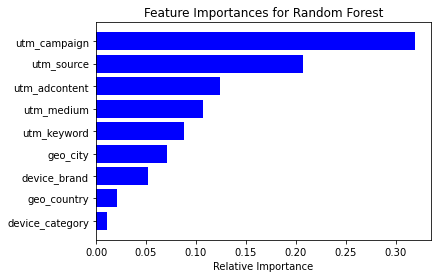

In [64]:
features = X_train.columns
importances_rfc = abs(rfc_best.feature_importances_).ravel()
indices_rfc = np.argsort(importances_rfc)

plt.barh(range(len(indices_rfc)), importances_rfc[indices_rfc], color='b', align='center')
plt.yticks(range(len(indices_rfc)), [features[i] for i in indices_rfc])
plt.title('Feature Importances for Random Forest')
plt.xlabel('Relative Importance');

**According to the "Feature Importances for Random Forest" histogram, the "utm_campaign" attribute has the highest weight.**

## 3.3. Best Model

In [65]:
df_full = pd.concat([df_train, df_test], axis=0)
X = df_full.drop(['event_action'], axis=1)
y = df_full['event_action']

In [68]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model in [logreg_best, rfc_best]:
    cv_score = cross_val_score(model, X, y, scoring='roc_auc', n_jobs=-2, cv=cv)
    print(
          f'Cross validation for {model}: \n'
          f'Mean score: {cv_score.mean()}.\n'
          f'Std score: {cv_score.std()}.\n'
         )

Cross validation for LogisticRegression(C=5, class_weight='balanced', l1_ratio=0.56, n_jobs=-2,
                   penalty='elasticnet', random_state=42, solver='saga'): 
Mean score: 0.6532022329511689.
Std score: 0.002035924829534992.

Cross validation for RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features='sqrt', min_samples_split=100,
                       n_estimators=200, n_jobs=-2, random_state=42): 
Mean score: 0.6808665811672487.
Std score: 0.0016338547538721439.



# 4. Result

**Based on the results of cross-validation, it was found that the RandomForestClassifier model showed the best result with a ROC-AUC value of 0.681.**

In [69]:
best_model = RandomForestClassifier(class_weight='balanced_subsample', max_depth=10, max_features='sqrt',
                                    min_samples_split=100, n_estimators=200, n_jobs=-2, random_state=42)
best_model.fit(X, y)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features='sqrt', min_samples_split=100,
                       n_estimators=200, n_jobs=-2, random_state=42)

In [71]:
with open('./model.pickle', 'wb') as file:
    pickle.dump(best_model, file)